# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
%matplotlib inline

# read in the json files

### Clean and encode portfolio dataset

In [2]:
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)

print(f"portfolio.shape: {portfolio.shape}")

print(f"portfolio.head:\n{portfolio.head()}")

portfolio.shape: (10, 6)
portfolio.head:
   reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f207df678b143eea3cee63160fa8bed  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7  


In [3]:
# Drop rows with any missing values
portfolio = portfolio.dropna()

# Reset the index after dropping rows
portfolio = portfolio.reset_index(drop=True)

# Rename 'id' column to 'offer_id' for clarity
portfolio = portfolio.rename(columns={'id': 'offer_id'})

# Ensure 'offer_id' is of type string
portfolio['offer_id'] = portfolio['offer_id'].astype(str)

# One-hot encode the 'channels' column
channels_dummies = portfolio['channels'].apply(lambda x: pd.Series(1, index=x)).fillna(0).astype('int32')
portfolio = pd.concat([portfolio.drop('channels', axis=1), channels_dummies], axis=1)

# Convert 'offer_type' to numerical values using label encoding
offer_type_mapping = {'bogo': 0, 'discount': 1, 'informational': 2}
portfolio['offer_type'] = portfolio['offer_type'].map(offer_type_mapping).astype('int32')

# Ensure numerical columns are of the correct type
numerical_columns = ['difficulty', 'duration', 'reward']
for col in numerical_columns:
    portfolio[col] = pd.to_numeric(portfolio[col], errors='coerce').astype('int32')

# Check for any inconsistent data types
print("\nData types in portfolio:")
print(portfolio.dtypes)

print("\nCleaned portfolio dataset:")
print(portfolio.head())
print(f"Shape of cleaned portfolio: {portfolio.shape}")



Data types in portfolio:
reward         int32
difficulty     int32
duration       int32
offer_type     int32
offer_id      object
email          int32
mobile         int32
social         int32
web            int32
dtype: object

Cleaned portfolio dataset:
   reward  difficulty  duration  offer_type                          offer_id  \
0      10          10         7           0  ae264e3637204a6fb9bb56bc8210ddfd   
1      10          10         5           0  4d5c57ea9a6940dd891ad53e9dbe8da0   
2       0           0         4           2  3f207df678b143eea3cee63160fa8bed   
3       5           5         7           0  9b98b8c7a33c4b65b9aebfe6a799e6d9   
4       5          20        10           1  0b1e1539f2cc45b7b9fa7c272da2e1d7   

   email  mobile  social  web  
0      1       1       1    0  
1      1       1       1    1  
2      1       1       0    1  
3      1       1       0    1  
4      1       0       0    1  
Shape of cleaned portfolio: (10, 9)



### Clean and encode profile dataset


In [4]:
profile = pd.read_json('data/profile.json', orient='records', lines=True)

print(f"profile.shape: {profile.shape}")

print(f"profile.head:\n{profile.head()}")

profile.shape: (17000, 5)
profile.head:
  gender  age                                id  became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804       NaN


In [5]:
# Clean profile dataset

# Remove any duplicate rows
profile = profile.drop_duplicates()

# Drop rows with null values
profile = profile.dropna()

# Reset index after dropping rows
profile = profile.reset_index(drop=True)

# Convert 'became_member_on' to datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

# Rename 'id' to 'customer_id' and ensure it's of type string
profile = profile.rename(columns={'id': 'customer_id'})
profile['customer_id'] = profile['customer_id'].astype(str)

# Ensure correct types for other columns
profile['age'] = profile['age'].astype('int32')
profile['income'] = profile['income'].astype('float32')

# Convert gender to number
# profile['gender'] = profile['gender'].map({'M': 0, 'F': 1, 'O': 2})
# One hot encode gender and remove the first category to avoid multicollinearity
gender_dummies = pd.get_dummies(profile['gender'], prefix='gender', dtype='int32')
profile = pd.concat([profile, gender_dummies], axis=1)
profile = profile.drop(columns=['gender'])


# Calculate membership duration
profile['membership_days'] = (pd.Timestamp.now() - profile['became_member_on']).dt.days.astype('int32') # type: ignore

# Drop the 'became_member_on' column as it's no longer needed
profile = profile.drop(columns=['became_member_on'])

print("\nCleaned and encoded profile dataset:")
print(profile.head())
print(f"Shape of cleaned profile: {profile.shape}")

# Display summary statistics
print("\nSummary statistics for profile:")
print(profile.describe())

# Display data types
print("\nData types in profile:")
print(profile.dtypes)



Cleaned and encoded profile dataset:
   age                       customer_id    income  gender_F  gender_M  \
0   55  0610b486422d4921ae7d2bf64640c50b  112000.0         1         0   
1   75  78afa995795e4d85b5d9ceeca43f5fef  100000.0         1         0   
2   68  e2127556f4f64592b11af22de27a7932   70000.0         0         1   
3   65  389bc3fa690240e798340f5a15918d5c   53000.0         0         1   
4   58  2eeac8d8feae4a8cad5a6af0499a211d   51000.0         0         1   

   gender_O  membership_days  
0         0             2607  
1         0             2674  
2         0             2322  
3         0             2398  
4         0             2488  
Shape of cleaned profile: (14825, 7)

Summary statistics for profile:
                age         income      gender_F      gender_M      gender_O  \
count  14825.000000   14825.000000  14825.000000  14825.000000  14825.000000   
mean      54.393524   65404.992188      0.413423      0.572277      0.014300   
std       17.383705  

### Clean and encode transcript dataset


In [6]:
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

print(f"transcript.shape: {transcript.shape}")

print(f"transcript.head:\n{transcript.head()}")


transcript.shape: (306534, 4)
transcript.head:
                             person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0  


In [7]:
# Extract data from 'value' column
# For offer_id, check both 'offer id' and 'offer_id' keys
transcript['offer_id'] = transcript.apply(lambda row: row['value'].get('offer id', '') or row['value'].get('offer_id', '') if row['event'] != 'transaction' else '', axis=1)

# Rename 'person' column to 'customer_id'
transcript.rename(columns={'person': 'customer_id'}, inplace=True)

# Display the first few rows of the updated dataframe
print(transcript.head())

                        customer_id           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  \
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0   
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0   
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0   
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0   
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0   

                           offer_id  
0  9b98b8c7a33c4b65b9aebfe6a799e6d9  
1  0b1e1539f2cc45b7b9fa7c272da2e1d7  
2  2906b810c7d4411798c6938adc9daaa5  
3  fafdcd668e3743c1bb461111dcafc2a4  
4  4d5c57ea9a6940dd891ad53e9dbe8da0  


In [8]:
# 'offer received', 'offer viewed', 'offer completed', 'transaction'
received_offer = transcript[transcript['event'] == 'offer received'].copy()

received_offer.drop(columns=['event', 'value'], inplace=True)

print(received_offer.head())

                        customer_id  time                          offer_id
0  78afa995795e4d85b5d9ceeca43f5fef     0  9b98b8c7a33c4b65b9aebfe6a799e6d9
1  a03223e636434f42ac4c3df47e8bac43     0  0b1e1539f2cc45b7b9fa7c272da2e1d7
2  e2127556f4f64592b11af22de27a7932     0  2906b810c7d4411798c6938adc9daaa5
3  8ec6ce2a7e7949b1bf142def7d0e0586     0  fafdcd668e3743c1bb461111dcafc2a4
4  68617ca6246f4fbc85e91a2a49552598     0  4d5c57ea9a6940dd891ad53e9dbe8da0


In [9]:
viewed_offer = transcript[transcript['event'] == 'offer viewed'].copy()
viewed_offer.drop(columns=['event', 'value'], inplace=True)

print(viewed_offer.head())


                            customer_id  time  \
12650  389bc3fa690240e798340f5a15918d5c     0   
12651  d1ede868e29245ea91818a903fec04c6     0   
12652  102e9454054946fda62242d2e176fdce     0   
12653  02c083884c7d45b39cc68e1314fec56c     0   
12655  be8a5d1981a2458d90b255ddc7e0d174     0   

                               offer_id  
12650  f19421c1d4aa40978ebb69ca19b0e20d  
12651  5a8bc65990b245e5a138643cd4eb9837  
12652  4d5c57ea9a6940dd891ad53e9dbe8da0  
12653  ae264e3637204a6fb9bb56bc8210ddfd  
12655  5a8bc65990b245e5a138643cd4eb9837  


In [10]:
completed_offer = transcript[transcript['event'] == 'offer completed'].copy()

# Extract reward from 'value' column, default to 0.0 if not present or if 'value' is not a dict
completed_offer['given_reward'] = completed_offer['value'].apply(lambda x: x.get('reward', 0.0) if isinstance(x, dict) else 0.0).astype('float32')

completed_offer.drop(columns=['event', 'value'], inplace=True)

print(completed_offer.head())


                            customer_id  time  \
12658  9fa9ae8f57894cc9a3b8a9bbe0fc1b2f     0   
12672  fe97aa22dd3e48c8b143116a8403dd52     0   
12679  629fc02d56414d91bca360decdfa9288     0   
12692  676506bad68e4161b9bbaffeb039626b     0   
12697  8f7dd3b2afe14c078eb4f6e6fe4ba97d     0   

                               offer_id  given_reward  
12658  2906b810c7d4411798c6938adc9daaa5           2.0  
12672  fafdcd668e3743c1bb461111dcafc2a4           2.0  
12679  9b98b8c7a33c4b65b9aebfe6a799e6d9           5.0  
12692  ae264e3637204a6fb9bb56bc8210ddfd          10.0  
12697  4d5c57ea9a6940dd891ad53e9dbe8da0          10.0  


In [11]:
transaction = transcript[transcript['event'] == 'transaction'].copy()

# Extract amount from 'value' column, default to 0.0 if not present
transaction['amount'] = transaction['value'].apply(lambda x: x.get('amount', 0.0) if isinstance(x, dict) else 0.0).astype('float32')

transaction.drop(columns=['event', 'value', 'offer_id'], inplace=True)

print(transaction.head())


                            customer_id  time     amount
12654  02c083884c7d45b39cc68e1314fec56c     0   0.830000
12657  9fa9ae8f57894cc9a3b8a9bbe0fc1b2f     0  34.560001
12659  54890f68699049c2a04d415abc25e717     0  13.230000
12670  b2f1cd155b864803ad8334cdf13c4bd2     0  19.510000
12671  fe97aa22dd3e48c8b143116a8403dd52     0  18.969999


In [12]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   customer_id  306534 non-null  object
 1   event        306534 non-null  object
 2   value        306534 non-null  object
 3   time         306534 non-null  int64 
 4   offer_id     306534 non-null  object
dtypes: int64(1), object(4)
memory usage: 11.7+ MB


In [13]:
# Remove duplicates based on 'offer_id' and 'customer_id'
final_transcript = transcript.drop_duplicates(subset=['offer_id', 'customer_id']).copy()

# Drop the 'amount' column from clean_transcript
final_transcript.drop(columns=['value'], inplace=True)

print(final_transcript.shape)



(79866, 4)


In [14]:
final_transcript['received_offer'] = final_transcript.set_index(['offer_id', 'customer_id']).index.isin(received_offer.set_index(['offer_id', 'customer_id']).index).astype('int32')
final_transcript['viewed_offer'] = final_transcript.set_index(['offer_id', 'customer_id']).index.isin(viewed_offer.set_index(['offer_id', 'customer_id']).index).astype('int32')
final_transcript['completed_offer'] = final_transcript.set_index(['offer_id', 'customer_id']).index.isin(completed_offer.set_index(['offer_id', 'customer_id']).index).astype('int32')

print(final_transcript.head())


                        customer_id           event  time  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received     0   
1  a03223e636434f42ac4c3df47e8bac43  offer received     0   
2  e2127556f4f64592b11af22de27a7932  offer received     0   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received     0   
4  68617ca6246f4fbc85e91a2a49552598  offer received     0   

                           offer_id  received_offer  viewed_offer  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9               1             1   
1  0b1e1539f2cc45b7b9fa7c272da2e1d7               1             1   
2  2906b810c7d4411798c6938adc9daaa5               1             1   
3  fafdcd668e3743c1bb461111dcafc2a4               1             1   
4  4d5c57ea9a6940dd891ad53e9dbe8da0               1             1   

   completed_offer  
0                1  
1                0  
2                0  
3                0  
4                0  


In [15]:
def calculate_delayed_time(final_transcript, event_type, reference_event='offer received'):
    if event_type not in ['view', 'complete']:
        raise ValueError("event_type must be either 'view' or 'complete'")
    
    event_df = viewed_offer if event_type == 'view' else completed_offer
    event_time = event_df.set_index(['offer_id', 'customer_id'])['time'].astype('int32')
    reference_time = final_transcript[final_transcript['event'] == reference_event].set_index(['offer_id', 'customer_id'])['time'].astype('int32')

    # Ensure both Series have unique indices
    event_time = event_time.reset_index()
    reference_time = reference_time.reset_index()

    # Perform the subtraction
    delayed_time = event_time.set_index(['offer_id', 'customer_id'])['time'].subtract(
        reference_time.set_index(['offer_id', 'customer_id'])['time'].astype('int32'), 
        fill_value=None
    )

    # Create a mapping of (offer_id, customer_id) to delayed_time
    delayed_time_map = delayed_time.to_dict()

    # Apply the mapping to clean_transcript
    column_name = f'delayed_{event_type}_time'
    final_transcript[column_name] = final_transcript.set_index(['offer_id', 'customer_id']).index.map(delayed_time_map)

# Calculate delayed view time
calculate_delayed_time(final_transcript,'view')

# Calculate delayed complete time
calculate_delayed_time(final_transcript, 'complete')

# Example of using a different reference event (if needed)
# calculate_delayed_time(final_transcript, 'view', 'some_other_event')

# Reset index of clean_transcript
final_transcript = final_transcript.reset_index(drop=True)

# Drop rows where event type is 'transaction'
final_transcript = final_transcript[final_transcript['event'] != 'transaction']

# Reset the index after dropping rows
final_transcript.reset_index(drop=True, inplace=True)


final_transcript.drop(columns=['event'], inplace=True)

In [16]:
def merge_transaction_and_reward_data(final_transcript, transaction, completed_offer):
    # Merge clean_transcript with transaction data to add the 'amount' column
    final_transcript = final_transcript.merge(
        transaction[['customer_id', 'time', 'amount']],
        on=['customer_id', 'time'],
        how='left'
    )

    # Fill NaN values in the 'amount' column with 0
    final_transcript['amount'] = final_transcript['amount'].fillna(0)

    # Merge clean_transcript with completed_offer data to add the 'given_reward' column
    final_transcript = final_transcript.merge(
        completed_offer[['customer_id', 'offer_id', 'given_reward']],
        on=['customer_id', 'offer_id'],
        how='left'
    )

    # Fill NaN values in the 'given_reward' column with 0
    final_transcript['given_reward'] = final_transcript['given_reward'].fillna(0)

    return final_transcript

# Use the function to update clean_transcript
final_transcript = merge_transaction_and_reward_data(final_transcript, transaction, completed_offer)

print(final_transcript.head())
print(f"Shape of clean_transcript after adding amount: {final_transcript.shape}")
final_transcript.drop(columns=['time'], inplace=True)



                        customer_id  time                          offer_id  \
0  78afa995795e4d85b5d9ceeca43f5fef     0  9b98b8c7a33c4b65b9aebfe6a799e6d9   
1  a03223e636434f42ac4c3df47e8bac43     0  0b1e1539f2cc45b7b9fa7c272da2e1d7   
2  e2127556f4f64592b11af22de27a7932     0  2906b810c7d4411798c6938adc9daaa5   
3  8ec6ce2a7e7949b1bf142def7d0e0586     0  fafdcd668e3743c1bb461111dcafc2a4   
4  68617ca6246f4fbc85e91a2a49552598     0  4d5c57ea9a6940dd891ad53e9dbe8da0   

   received_offer  viewed_offer  completed_offer  delayed_view_time  \
0               1             1                1                6.0   
1               1             1                0              624.0   
2               1             1                0               18.0   
3               1             1                0              522.0   
4               1             1                0               84.0   

   delayed_complete_time  amount  given_reward  
0                  132.0     0.0           5.0  


In [17]:

print(final_transcript[(final_transcript['completed_offer'] == 1) & (final_transcript['amount'] > 0.0)])


                            customer_id                          offer_id  \
39     676506bad68e4161b9bbaffeb039626b  ae264e3637204a6fb9bb56bc8210ddfd   
40     9fa9ae8f57894cc9a3b8a9bbe0fc1b2f  2906b810c7d4411798c6938adc9daaa5   
127    fe97aa22dd3e48c8b143116a8403dd52  fafdcd668e3743c1bb461111dcafc2a4   
147    629fc02d56414d91bca360decdfa9288  9b98b8c7a33c4b65b9aebfe6a799e6d9   
148    2481f1fcfbcb4b288e5a03af02d95373  2906b810c7d4411798c6938adc9daaa5   
...                                 ...                               ...   
67787  569bd9890e74463f84e96f4b4951f45a  fafdcd668e3743c1bb461111dcafc2a4   
67790  b7ff2824d6b14653900c9c55b3df78d3  2906b810c7d4411798c6938adc9daaa5   
67799  3408fd05c781401f8442fb6dbaaea9c7  0b1e1539f2cc45b7b9fa7c272da2e1d7   
67813  8a776d222f174aa089866b2725721eec  2298d6c36e964ae4a3e7e9706d1fb8c2   
67853  0b250fe9fab14dac96ba542a572da081  2298d6c36e964ae4a3e7e9706d1fb8c2   

       received_offer  viewed_offer  completed_offer  delayed_view_time  \


In [18]:
final_transcript[final_transcript['viewed_offer'] == 0]

,customer_id,offer_id,received_offer,viewed_offer,completed_offer,delayed_view_time,delayed_complete_time,amount,given_reward
8,2eeac8d8feae4a8cad5a6af0499a211d,3f207df678b143eea3cee63160fa8bed,1,0,0,NaN,NaN,0.00,0.0
21,65aba5c617294649aeb624da249e1ee5,2906b810c7d4411798c6938adc9daaa5,1,0,0,NaN,NaN,0.00,0.0
24,868317b9be554cb18e50bc68484749a2,2906b810c7d4411798c6938adc9daaa5,1,0,1,NaN,132.0,0.00,2.0
27,4beeb3ed64dd4898b0edf2f6b67426d3,2906b810c7d4411798c6938adc9daaa5,1,0,1,NaN,120.0,0.00,2.0
29,25c906289d154b66bf579693f89481c9,2906b810c7d4411798c6938adc9daaa5,1,0,0,NaN,NaN,0.00,0.0
...,...,...,...,...,...,...,...,...,...
67856,10316535e185400fb093c371d62254e3,3f207df678b143eea3cee63160fa8bed,1,0,0,NaN,NaN,0.00,0.0
67861,ff737c250d2343729ade04c4f6eb1001,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,NaN,NaN,4.78,0.0
67862,97ee6e7a12fe4064b260fa48bdd0330f,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,NaN,NaN,0.00,0.0
67863,bf3069b178fe40d789dd027901bc406b,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,NaN,NaN,0.00,0.0


### Create a unified data set

In [19]:
len(final_transcript)

67871

In [20]:
def merge_and_clean_data(final_transcript, right_dataset, key, direct):
    # Merge profile to transcript by customer_id
    merged_dataset = final_transcript.merge(right_dataset, on=key, how=direct)

    # Drop the key column
    merged_dataset = merged_dataset.drop(key, axis=1)

    print("\nMerged dataset:")
    print(merged_dataset.head())
    print(f"Shape of merged dataset: {merged_dataset.shape}")

    # Display data types
    print("\nData types in merged dataset:")
    print(merged_dataset.dtypes)

    # Verify data types in merged dataset
    print("\nVerifying data types in merged dataset:")
    for column in merged_dataset.columns:
        print(f"{column}: {merged_dataset[column].dtype}")

    return merged_dataset


In [21]:
len(profile['customer_id'].unique())

14825

In [22]:
# Create Viewed & Completed Offers Dataset for analysis
final_dataset = merge_and_clean_data(final_transcript, profile, 'customer_id', 'inner')
final_dataset = merge_and_clean_data(final_dataset, portfolio, 'offer_id', 'inner')



Merged dataset:
                           offer_id  received_offer  viewed_offer  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9               1             1   
1  2906b810c7d4411798c6938adc9daaa5               1             1   
2  f19421c1d4aa40978ebb69ca19b0e20d               1             1   
3  f19421c1d4aa40978ebb69ca19b0e20d               1             1   
4  3f207df678b143eea3cee63160fa8bed               1             0   

   completed_offer  delayed_view_time  delayed_complete_time  amount  \
0                1                6.0                  132.0     0.0   
1                0               18.0                    NaN     0.0   
2                1              504.0                  600.0     0.0   
3                1              504.0                  600.0     0.0   
4                0                NaN                    NaN     0.0   

   given_reward  age    income  gender_F  gender_M  gender_O  membership_days  
0           5.0   75  100000.0         1         0     

In [23]:
main_dataset = final_dataset
main_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59724 entries, 0 to 59723
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   received_offer         59724 non-null  int32  
 1   viewed_offer           59724 non-null  int32  
 2   completed_offer        59724 non-null  int32  
 3   delayed_view_time      46679 non-null  float64
 4   delayed_complete_time  32444 non-null  float64
 5   amount                 59724 non-null  float32
 6   given_reward           59724 non-null  float32
 7   age                    59724 non-null  int32  
 8   income                 59724 non-null  float32
 9   gender_F               59724 non-null  int32  
 10  gender_M               59724 non-null  int32  
 11  gender_O               59724 non-null  int32  
 12  membership_days        59724 non-null  int32  
 13  reward                 59724 non-null  int32  
 14  difficulty             59724 non-null  int32  
 15  du

## Calculation statistics after clean and encode data


### Best performing offers

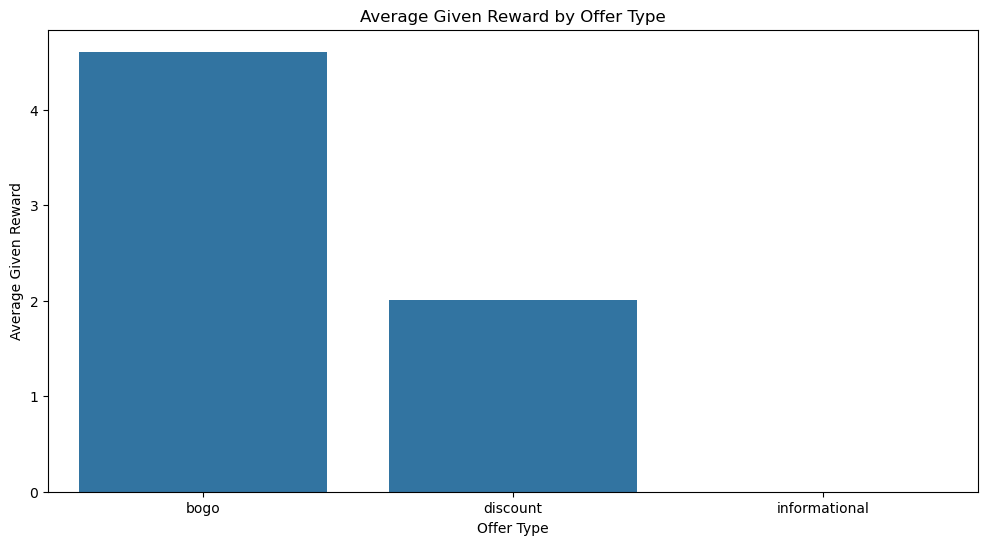


Best performing offers based on average given reward:
   offer_type  given_reward  delayed_complete_time    offer_label
0           0      4.607172             130.797483           bogo
1           1      2.011806             152.800652       discount
2           2      0.000000                    NaN  informational

The best performing offer is 'bogo' with an average given reward of 4.61 and an average response time of 130.80 minutes.


In [24]:
# Find the best performing offers

# Group by offer type and calculate the mean of the given reward and response time
offer_performance = main_dataset.groupby('offer_type').agg({
    'given_reward': 'mean',
    'delayed_complete_time': 'mean'
}).reset_index()

# Sort by the mean given reward to find the best performing offers
offer_performance = offer_performance.sort_values('given_reward', ascending=False)

# Create a dictionary to map offer types to labels
offer_type_labels = {0: 'bogo', 1: 'discount', 2: 'informational'}

# Map the offer types to their corresponding labels
offer_performance['offer_label'] = offer_performance['offer_type'].map(offer_type_labels)

# Visualize the performance of different offer types
plt.figure(figsize=(12, 6))
sns.barplot(x='offer_label', y='given_reward', data=offer_performance)
plt.title('Average Given Reward by Offer Type')
plt.xlabel('Offer Type')
plt.ylabel('Average Given Reward')
plt.show()

# Print the best performing offers
print("\nBest performing offers based on average given reward:")
print(offer_performance)

# Highlight the best performing offer
best_offer = offer_performance.iloc[0]
print(f"\nThe best performing offer is '{best_offer['offer_label']}' with an average given reward of {best_offer['given_reward']:.2f} and an average response time of {best_offer['delayed_complete_time']:.2f} minutes.")

### Identify which groups of people are most responsive to each type of offer, and how best to present each type of offer.


In [25]:
main_dataset.columns

Index(['received_offer', 'viewed_offer', 'completed_offer',
       'delayed_view_time', 'delayed_complete_time', 'amount', 'given_reward',
       'age', 'income', 'gender_F', 'gender_M', 'gender_O', 'membership_days',
       'reward', 'difficulty', 'duration', 'offer_type', 'email', 'mobile',
       'social', 'web'],
      dtype='object')

In [26]:
# Create a model to predict if a customer will view an offer
def predict_offer_status(offer_status, core_features):
    # Prepare the data
    X = main_dataset[core_features]
    y = main_dataset[offer_status]

    # Split the data into training and testing sets
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create and train the model (using Random Forest as an example)
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score, classification_report

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy: {accuracy:.2f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Feature importance
    feature_importance = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_})
    feature_importance = feature_importance.sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title(f'Feature Importance for Predicting Offer {"Viewed" if offer_status == 'viewed_offer' else "Completed"}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

    print("\nTop 5 most important features:")
    print(feature_importance.head())


Model Accuracy: 0.83

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.56      0.59      2641
           1       0.88      0.90      0.89      9304

    accuracy                           0.83     11945
   macro avg       0.75      0.73      0.74     11945
weighted avg       0.82      0.83      0.82     11945



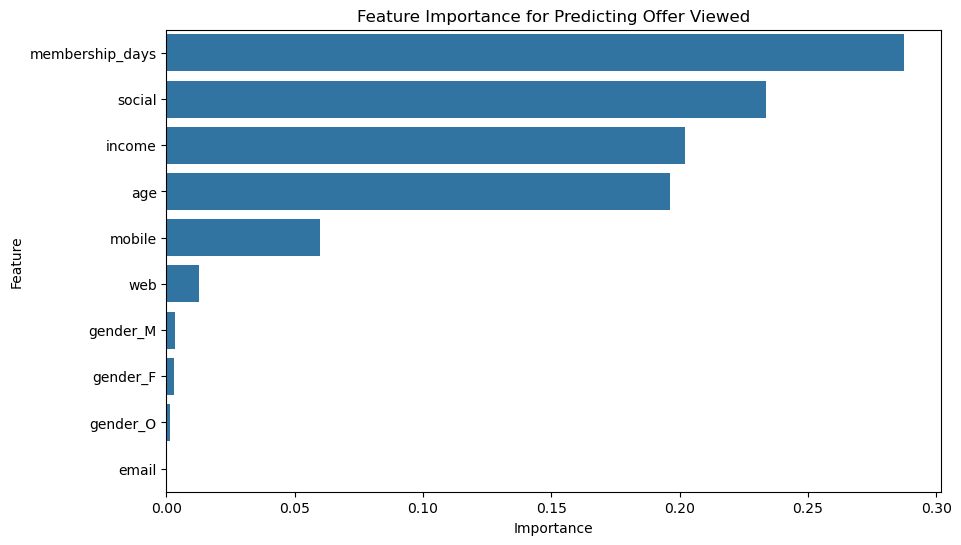


Top 5 most important features:
           feature  importance
5  membership_days    0.287590
8           social    0.233723
1           income    0.202223
0              age    0.196217
7           mobile    0.059808


In [27]:
viewed_features = ['age', 'income', 'gender_M', 'gender_F', 'gender_O', 'membership_days', 'email', 'mobile', 'social', 'web']
# Call the function with the viewed_offer data
predict_offer_status('viewed_offer', viewed_features)


Model Accuracy: 0.79

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.73      0.76      5469
           1       0.79      0.84      0.82      6476

    accuracy                           0.79     11945
   macro avg       0.79      0.79      0.79     11945
weighted avg       0.79      0.79      0.79     11945



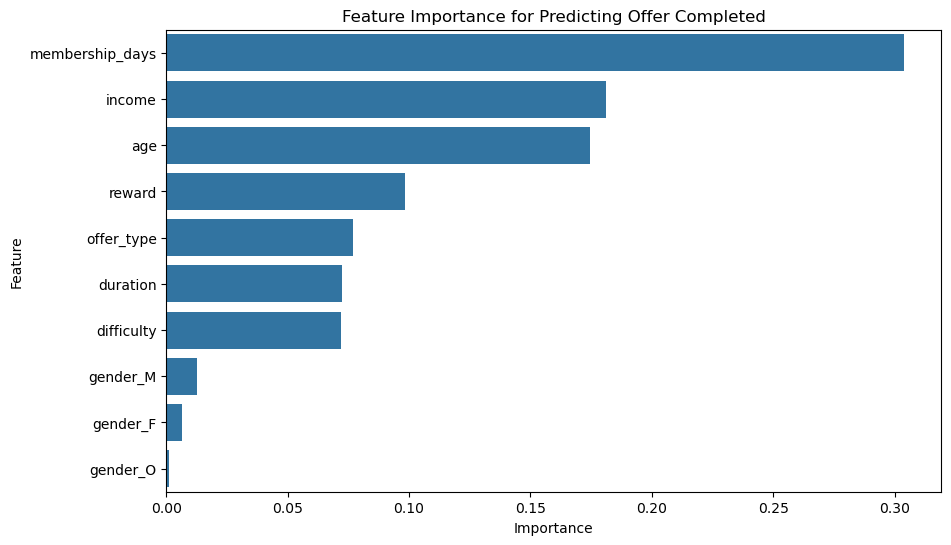


Top 5 most important features:
           feature  importance
5  membership_days    0.304103
1           income    0.181082
0              age    0.174618
6           reward    0.098508
9       offer_type    0.076875


In [28]:
completed_features = ['age', 'income', 'gender_M', 'gender_F', 'gender_O', 'membership_days', 'reward', 'difficulty', 'duration', 'offer_type']

predict_offer_status('completed_offer', completed_features)

Most Attractive Offer:
Offer ID: 1.0
Fulfillment Rate: 95.53%
View Rate: 73.24%
Completion Rate: 69.97%

Offer Characteristics:
Reward: $2.00
Difficulty: $10.00
Duration: 7.0 hours

Feature Ranking for Offer Attractiveness:
duration: 0.3721
difficulty: 0.2948
reward: 0.2238


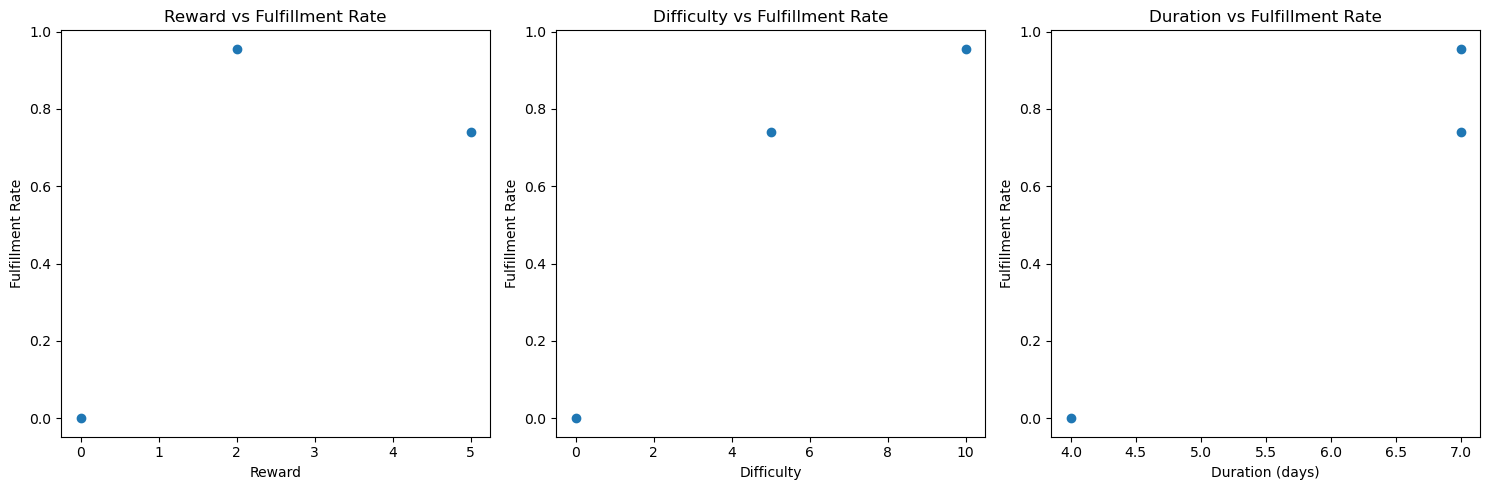


Insights on Offer Attractiveness:
1. The most attractive offer has the highest fulfillment rate, indicating that it successfully motivates customers to complete the offer after viewing it.
2. The ranking of offer features (reward, difficulty, duration) shows their relative importance in influencing offer completion.
3. The scatter plots visualize how each feature relates to the fulfillment rate, helping to identify trends or patterns in offer attractiveness.
4. Consider the balance between reward and difficulty, as well as the optimal duration, when designing future offers to maximize their attractiveness and completion rates.


In [32]:
# Analyze offer attractiveness and rank features

# Group the data by offer_id and calculate the view and completion rates
offer_performance = main_dataset.groupby('offer_type').agg({
    'viewed_offer': 'mean',
    'completed_offer': 'mean',
    'reward': 'first',
    'difficulty': 'first',
    'duration': 'first'
}).reset_index()

# Calculate the fulfillment rate (completed offers among viewed offers)
offer_performance['fulfillment_rate'] = offer_performance['completed_offer'] / offer_performance['viewed_offer']

# Sort offers by fulfillment rate to find the most attractive offer
most_attractive_offer = offer_performance.sort_values('fulfillment_rate', ascending=False).iloc[0]

print("Most Attractive Offer:")
print(f"Offer ID: {most_attractive_offer['offer_type']}")
print(f"Fulfillment Rate: {most_attractive_offer['fulfillment_rate']:.2%}")
print(f"View Rate: {most_attractive_offer['viewed_offer']:.2%}")
print(f"Completion Rate: {most_attractive_offer['completed_offer']:.2%}")
print("\nOffer Characteristics:")
print(f"Reward: ${most_attractive_offer['reward']:.2f}")
print(f"Difficulty: ${most_attractive_offer['difficulty']:.2f}")
print(f"Duration: {most_attractive_offer['duration']} hours")

# Rank features by their correlation with offer completion
feature_correlations = main_dataset[['completed_offer', 'reward', 'difficulty', 'duration']].corr()['completed_offer'].abs().sort_values(ascending=False)

print("\nFeature Ranking for Offer Attractiveness:")
for feature, correlation in feature_correlations.items():
    if feature != 'completed_offer':
        print(f"{feature}: {correlation:.4f}")

# Visualize the relationship between offer characteristics and fulfillment rate
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.scatter(offer_performance['reward'], offer_performance['fulfillment_rate'])
plt.xlabel('Reward')
plt.ylabel('Fulfillment Rate')
plt.title('Reward vs Fulfillment Rate')

plt.subplot(132)
plt.scatter(offer_performance['difficulty'], offer_performance['fulfillment_rate'])
plt.xlabel('Difficulty')
plt.ylabel('Fulfillment Rate')
plt.title('Difficulty vs Fulfillment Rate')

plt.subplot(133)
plt.scatter(offer_performance['duration'], offer_performance['fulfillment_rate'])
plt.xlabel('Duration (days)')
plt.ylabel('Fulfillment Rate')
plt.title('Duration vs Fulfillment Rate')

plt.tight_layout()
plt.show()

# Provide insights based on the analysis
print("\nInsights on Offer Attractiveness:")
print("1. The most attractive offer has the highest fulfillment rate, indicating that it successfully motivates customers to complete the offer after viewing it.")
print("2. The ranking of offer features (reward, difficulty, duration) shows their relative importance in influencing offer completion.")
print("3. The scatter plots visualize how each feature relates to the fulfillment rate, helping to identify trends or patterns in offer attractiveness.")
print("4. Consider the balance between reward and difficulty, as well as the optimal duration, when designing future offers to maximize their attractiveness and completion rates.")
